<a href="https://colab.research.google.com/github/lemurchik65/VfhECz15082000/blob/master/Lesson_11_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Перенос обучения (Transfer learning)
В задаче будет использоваться VGG16 сеть, переобученная чтобы отличать собак и кошек на основе урезанного датасета. Идея в том, что при ограниченном датасете нам нужно, чтобы умение выделять важные черты на изображении было получено ранее, а конкретика датасета обучала только финальный вывод сети. Без использования переноса обучения, используя свою сеть с нуля, мы скорее всего столкнёмся с переобучением.
Импортируем стандартные numpy, tensorflow, matplotlib; а также набор библиотек для работы с файлами: glob для поиска файлов датасета по маске, shutil и os для файловых операций над группами файлов или индивидуальными файлами.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import glob
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

np.random.seed(42) # So we will copy always the same files to our subdataset

Начнём готовить датасет. Для этого нужно скачать датасет по ссылке с https://www.kaggle.com/c/dogs-vs-cats/data и распаковать train папку рядом с блокнотом. Если файлы будут найдены, то следующий лок выполнится корректно.

In [5]:
# Directory to look for dataset
directory_with_dataset = "drive/My Drive/train/*"

files = glob.glob(directory_with_dataset)
if len(files) == 0:
    raise(FileNotFoundError("No relevant files found in " + directory_with_dataset +" Did you forget to download dataset from https://www.kaggle.com/c/dogs-vs-cats/data and put train dir in datasets folder?"))
else:
    cat_files = [fn for fn in files if 'cat' in fn]
    dog_files = [fn for fn in files if 'dog' in fn]
    print("Found {} cats and {} dogs files.".format(len(cat_files), len(dog_files)))

Found 12557 cats and 12540 dogs files.


Теперь составим датасет поменьше, так как выше мы заявили, что хотим преодолеть проблему переобучения, а для этого надо создать проблему переобучения, для чего датасет должен быть меньше. Для этого выберем равное количество собак и кошек случайно и сделаем выборку для обучения, для валидации, для теста. Начнём с имен файлов.

In [6]:
train_size = 3000
val_size = 1000
test_size = 1000

cat_train = np.random.choice(cat_files, size=int(train_size/2), replace=False)
dog_train = np.random.choice(dog_files, size=int(train_size/2), replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=int(val_size/2), replace=False)
dog_val = np.random.choice(dog_files, size=int(val_size/2), replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=int(test_size/2), replace=False)
dog_test = np.random.choice(dog_files, size=int(test_size/2), replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


Теперь у нас есть имена файлов наших выборок и мы можем для удобства скопировать их из исходной директории.

In [0]:
train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

train_dir = 'output/chunk/training_data'
val_dir = 'output/chunk/validation_data'
test_dir = 'output/chunk/test_data'

os.mkdir("output") if not os.path.isdir("output") else None
os.mkdir("output/chunk") if not os.path.isdir("output/chunk") else None
os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

Теперь загрузим в память сами картинки. Возьмём их в подготовленных папках, откроем, преобразуем в numpy с типом float, не забудем отнормировать (помним, что нейронные сети лучше работают с нормированными значениями). Для ответов выборки нам нам найти слово dog в названии файла и это будет класс 1, а кошки тогда класс 0. В конце проверим, что картинки загрузились и обозначаются верным классом.

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)
Image shape: (150, 150, 3)


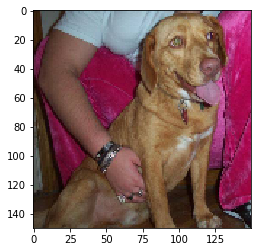

It's a dog


In [9]:
IMG_DIM = (150, 150)

try:
    train_files = glob.glob(train_dir + '/*')
    train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM), dtype='float32')/255 for img in train_files]
    train_imgs = np.array(train_imgs) # img_to_array returns numpy array already, but we have a list of them, so we convert again
    train_labels = np.asarray([1 if 'dog' in fn else 0 for fn in train_files])

    validation_files = glob.glob(val_dir + '/*')
    validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM), dtype='float32')/255 for img in validation_files]
    validation_imgs = np.array(validation_imgs) # img_to_array returns numpy array already, but we have a list of them, so we convert again
    validation_labels = np.asarray([1 if 'dog' in fn else 0 for fn in validation_files])

    print('Train dataset shape:', train_imgs.shape, 
    '\tValidation dataset shape:', validation_imgs.shape)
    print('Image shape:', train_imgs[0].shape)
except IndexError:
    print("\nLooks like you have problem with path delimiters. Windows users must use \\ instead of / and visa versa.")
    raise
# Test image
plt.imshow(array_to_img(train_imgs[20]))
plt.show()
# Test label
if train_labels[20] == 1:
    print("It's a dog")
else:
    print("It's a cat")

## Обучение CNN
Зададим параметры обучения: эпохи и размер батча. Последний должен быть делителем для размера выборки.

In [0]:
batch_size = 30
epochs = 10

Нашу сеть построим обычным образом, чередуя Conv2D и MaxPooling2D слои, заканчивая полносвязными слоями для принятия решения на основе сверточного анализа картинки и слоем из одного нейрона чтобы его выход определял класс объекта.
![image.png](attachment:image.png)

In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

cnn_model = Sequential()

cnn_model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=train_imgs[0].shape))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))


cnn_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

cnn_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d

Обучим свёрточную сеть.

In [12]:
cnn_history = cnn_model.fit(x=train_imgs, y=train_labels,
                    validation_data=(validation_imgs, validation_labels),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 10s 3ms/sample - loss: 0.7473 - acc: 0.5050 - val_loss: 0.6788 - val_acc: 0.5830
Epoch 2/30
3000/3000 [==============================] - 3s 865us/sample - loss: 0.6845 - acc: 0.5533 - val_loss: 0.6647 - val_acc: 0.6060
Epoch 3/30
3000/3000 [==============================] - 3s 866us/sample - loss: 0.6527 - acc: 0.6187 - val_loss: 0.6533 - val_acc: 0.6180
Epoch 4/30
3000/3000 [==============================] - 3s 861us/sample - loss: 0.6101 - acc: 0.6690 - val_loss: 0.6223 - val_acc: 0.6500
Epoch 5/30
3000/3000 [==============================] - 3s 863us/sample - loss: 0.5224 - acc: 0.7433 - val_loss: 0.6275 - val_acc: 0.6700
Epoch 6/30
3000/3000 [==============================] - 3s 874us/sample - loss: 0.3641 - acc: 0.8347 - val_loss: 0.7255 - val_acc: 0.6350
Epoch 7/30
3000/3000 [==============================] - 3s 866us/sample - loss: 0.1820 - acc: 0.9287 - val_loss: 1.1201 - val

Результаты обучения лучше всего смотреть графически. Нас интересует переобучение. Напомню. что переобучение сразу видно по отличиям графиков валидации и обучения. Для этого определим функцию, которая будет получать историю обучения и показывать точность и функцию потерь в удобном виде с подписями осей, отступами и т.п.

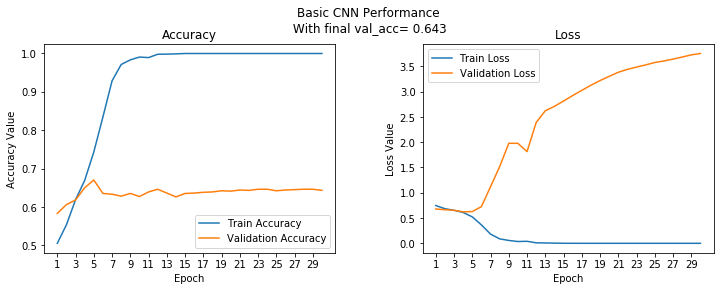

In [14]:
def show_history(history, label="Default label"):
    label = label +'\n With final val_acc= '+ str(history.history['val_acc'][-1:][0])
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(label, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)
    epochs = len(history.history["loss"])

    epoch_list = list(range(1,epochs+1))
    
    ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, epochs+1, 2))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, epochs+1, 2))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

show_history(cnn_history, 'Basic CNN Performance')

Итак, модель достигла точности в 70% на валидации и с некоторой эпохи началось переобучение (увеличение потерь на валидации с ростом номера эпохи). Прежде чем перейти к переносу обучения стоит побороться с переобучением стандартными методами.

### Задание 1
Имея ту же самую выборку и другую сеть с таким же или примерно таким же количеством коэффициентов, используй известные тебе способы борьбы с переобучением, выведи графики обучения и покажи, что эффект переобучения удалось снизить.

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
3000/3000 [==============================] - 4s 1ms/sample - loss: 0.7759 - acc: 0.5527 - val_loss: 0.7049 - val_acc: 0.5650
Epoch 2/10
3000/3000 [==============================] - 3s 1ms/sample - loss: 0.6573 - acc: 0.6133 - val_loss: 0.6989 - val_acc: 0.5640
Epoch 3/10
3000/3000 [==============================] - 3s 1ms/sample - loss: 0.6246 - acc: 0.6450 - val_loss: 0.7713 - val_acc: 0.5350
Epoch 4/10
3000/3000 [==============================] - 3s 1ms/sample - loss: 0.6149 - acc: 0.6630 - val_loss: 0.6902 - val_acc: 0.6110
Epoch 5/10
3000/3000 [==============================] - 3s 1ms/sample - loss: 0.5819 - acc: 0.6810 - val_loss: 0.6602 - val_acc: 0.6380
Epoch 6/10
3000/3000 [==============================] - 3s 1ms/sample - loss: 0.5416 - acc: 0.7260 - val_loss: 1.1174 - val_acc: 0.5990
Epoch 7/10
3000/3000 [==============================] - 3s 1ms/sample - loss: 0.5072 - acc: 0.7487 - val_loss: 0.5871 - val_acc: 0.7260


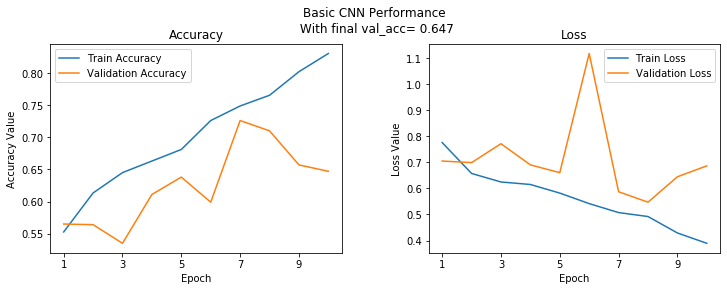

In [18]:
# Type your code here
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

cnn_model = Sequential()
cnn_model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=train_imgs[0].shape))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.1))

cnn_model.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(128, kernel_size=(3, 3),activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(Dense(1, activation='sigmoid'))


cnn_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

#cnn_model.summary()

cnn_history = cnn_model.fit(x=train_imgs, y=train_labels,
                    validation_data=(validation_imgs, validation_labels),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)
show_history(cnn_history, 'Basic CNN Performance')

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
3000/3000 [==============================] - 5s 2ms/sample - loss: 0.0509 - acc: 0.9850 - val_loss: 0.9304 - val_acc: 0.7100
Epoch 2/10
3000/3000 [==============================] - 4s 1ms/sample - loss: 0.0425 - acc: 0.9833 - val_loss: 1.0267 - val_acc: 0.7220
Epoch 3/10
3000/3000 [==============================] - 4s 1ms/sample - loss: 0.0395 - acc: 0.9853 - val_loss: 1.0709 - val_acc: 0.7270
Epoch 4/10
3000/3000 [==============================] - 4s 1ms/sample - loss: 0.0254 - acc: 0.9903 - val_loss: 1.2846 - val_acc: 0.7110
Epoch 5/10
3000/3000 [==============================] - 4s 1ms/sample - loss: 0.0308 - acc: 0.9897 - val_loss: 1.3271 - val_acc: 0.6950
Epoch 6/10
3000/3000 [==============================] - 4s 1ms/sample - loss: 0.0255 - acc: 0.9920 - val_loss: 1.1548 - val_acc: 0.7310
Epoch 7/10
3000/3000 [==============================] - 4s 1ms/sample - loss: 0.0334 - acc: 0.9890 - val_loss: 1.3674 - val_acc: 0.7300


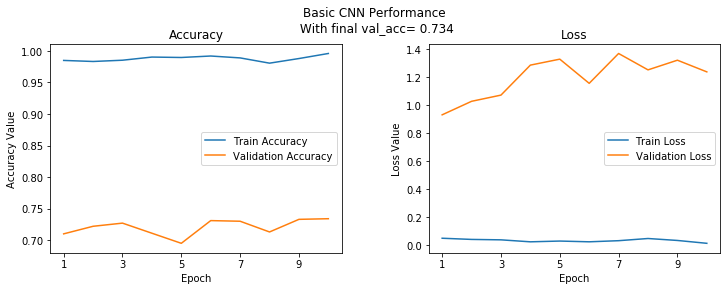

In [0]:
cnn_history = cnn_model.fit(x=train_imgs, y=train_labels,
                    validation_data=(validation_imgs, validation_labels),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)
show_history(cnn_history, 'Basic CNN Performance')

## Перенос обучения с VGG16
Вспомним основные свойства VGG16. Эта сеть тренировалась на ImageNet с 1000 классами (там есть несколько пород собак и кошки). Эта сеть - классификатор. Она имеет традиционную архитектуру сверточных сетей. Нам нужно выделить место, где появляются высокоуровневые свойства изображения. Это будет последний MaxPooling слой перед полносвязными слоями анализа этих свойств.
![image.png](attachment:image.png)

Вспоминаем, что есть 2 способа использовать перенос обучения: использования готового анализа свойств изображения (feature extraction) и точная подстройка (fine tuning).
![image.png](attachment:image.png)
Мы начнём с использования свойств.

### Перенос свойств (Feature extraction)
Мы воспользуемся готовой моделью из библиотеки `tensorflow.keras.applications`. Она импортируется из интернета автоматически, но мы должны указать, включать ли полносвязные слои на выходе (`include_top`). Они нам как раз и не нужны. А вот веса `weights` нужны. Мы задаём в `input_shape` размерность входных изображений, которую выбрали в начале.
### Вопрос
Каким образом можно поменять эту размерность, если сеть уже готовая и обученная?

Далее соорудим модель как vgg16 со слоем Flatten в конце. Нам важно сделать всю эту модель неизменяемой, чтобы не сломать те умения, что мы собираемся переиспользовать. Они и так хороши.

In [19]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow as tf

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=train_imgs[0].shape)

# We want to attach 
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()

58892288/58889256 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

Теперь мы можем взять готовую, неизменяемую модель с выводом всех итоговых сигналов и применить её к нашей выборке. Мы тогда получим новую выборку, состоящую из неких важных свойств нашей исходной выборки.

In [20]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs)

print('Train Bottleneck Features:', train_features_vgg.shape, 
'\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (3000, 8192) 	Validation Bottleneck Features: (1000, 8192)


Собственно от VGG16 мы уже всё, что нужно, получили. Теперь мы можем обучить нашу новую сеть на выборке с суффиксом `_vgg`. Сеть мы сразу возьмём такую же, как была у нас свёрточная, но всю сверточную часть опустим, ведь мы её взяли из VGG16.

In [21]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

input_shape = vgg_model.output_shape[1]

vggfe_model = Sequential()
vggfe_model.add(InputLayer(input_shape=(input_shape,)))
vggfe_model.add(Dense(512, activation='relu', input_dim=input_shape))
vggfe_model.add(Dense(512, activation='relu'))
vggfe_model.add(Dense(1, activation='sigmoid'))

vggfe_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

vggfe_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


Обучим нашу сеть.

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 1s 288us/sample - loss: 0.3934 - acc: 0.8217 - val_loss: 0.2680 - val_acc: 0.8910
Epoch 2/30
3000/3000 [==============================] - 1s 194us/sample - loss: 0.2541 - acc: 0.8910 - val_loss: 0.2278 - val_acc: 0.9070
Epoch 3/30
3000/3000 [==============================] - 1s 190us/sample - loss: 0.1935 - acc: 0.9253 - val_loss: 0.2277 - val_acc: 0.9000
Epoch 4/30
3000/3000 [==============================] - 1s 189us/sample - loss: 0.1469 - acc: 0.9390 - val_loss: 0.2200 - val_acc: 0.9130
Epoch 5/30
3000/3000 [==============================] - 1s 189us/sample - loss: 0.1162 - acc: 0.9543 - val_loss: 0.3917 - val_acc: 0.8370
Epoch 6/30
3000/3000 [==============================] - 1s 182us/sample - loss: 0.0831 - acc: 0.9700 - val_loss: 0.2394 - val_acc: 0.9160
Epoch 7/30
3000/3000 [==============================] - 1s 183us/sample - loss: 0.0644 - acc: 0.9760 - val_loss: 0.2356 - va

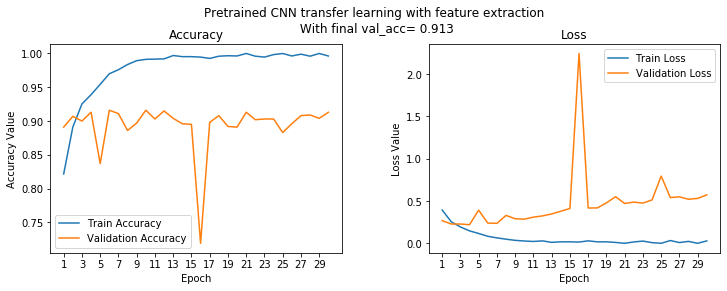

In [22]:
vggfe_history = vggfe_model.fit(x=train_features_vgg, y=train_labels,
                    validation_data=(validation_features_vgg, validation_labels),
                    batch_size=batch_size,
                    epochs=30,
verbose=1)
show_history(vggfe_history, label = "Pretrained CNN transfer learning with feature extraction")

Заметил как быстро сеть обучилась? Заметил, что точность на валидации возрасла до 88%? Вот это сила переноса обучения. Кстати, здесь мы тоже с переобучением не боролись, так что можешь модифицировать сеть тем же способом и еще повысить результат.
### Задание 2
Метод классификации построен и даёт хорошие результаты, а теперь нужно воспользоваться этим методом и предсказать класс случайной картинки из набора для валидации. напиши код, дающий значение `prediction`.

Prediction: It's a dog.
Actually it's a dog.


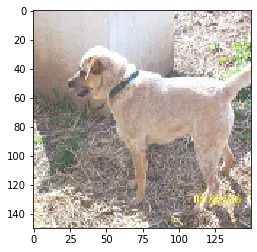

In [23]:
random_val_image = np.random.randint(0, len(validation_imgs))
# Type your code here
img_to_predict = validation_imgs[random_val_image]
img_to_predict = img_to_predict[np.newaxis, ...]

fs = vgg_model.predict(img_to_predict, verbose=0)
prediction = vggfe_model.predict(fs)

if prediction < 0.5:
    print("Prediction: It's a cat.")
else:
    print("Prediction: It's a dog.")
print("Actually it's a {}.".format("dog" if validation_labels[random_val_image] else "cat"))
plt.imshow(array_to_img(validation_imgs[random_val_image]))
plt.show()

### Точная подстройка (Fine tuning)
Теперь мы можем попробовать донастроить сеть. Для этого мы выберем 1 или 2 последних блока и пометим все их слои, как обучаемые.
### Задание 3
Пометь в vgg модели слои последних 1-2 блоков, как обучаемые.

In [24]:
# Type your code here
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=train_imgs[0].shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

print('Layers count: '+ str(len(vgg_model.layers)))
for i, layer in enumerate(vgg_model.layers):
    if i<=15:
        layer.trainable = False
        print(f'Layer-{i}   {layer.name}\t not trainable at object:')
    else:
        print(f'Layer-{i}   {layer.name}\t trainable at object:')

vgg_model.summary()

Layers count: 20
Layer-0   input_3	 not trainable at object:
Layer-1   block1_conv1	 not trainable at object:
Layer-2   block1_conv2	 not trainable at object:
Layer-3   block1_pool	 not trainable at object:
Layer-4   block2_conv1	 not trainable at object:
Layer-5   block2_conv2	 not trainable at object:
Layer-6   block2_pool	 not trainable at object:
Layer-7   block3_conv1	 not trainable at object:
Layer-8   block3_conv2	 not trainable at object:
Layer-9   block3_conv3	 not trainable at object:
Layer-10   block3_pool	 not trainable at object:
Layer-11   block4_conv1	 not trainable at object:
Layer-12   block4_conv2	 not trainable at object:
Layer-13   block4_conv3	 not trainable at object:
Layer-14   block4_pool	 not trainable at object:
Layer-15   block5_conv1	 not trainable at object:
Layer-16   block5_conv2	 trainable at object:
Layer-17   block5_conv3	 trainable at object:
Layer-18   block5_pool	 trainable at object:
Layer-19   flatten_5	 trainable at object:
Model: "model_1"
_____

Теперь мы можем сделать сеть, которая начинается с vgg с частично разблокированными коэффициентами, а продолжается нашими стандартными полносвязными слоями. Только надо использовать небольшой коэффициент градиента, чтобы не раскачать в первую очередь слои от VGG16.

In [25]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

vggft_model = Sequential()
vggft_model.add(vgg_model)
vggft_model.add(Dense(512, activation='relu', input_dim=input_shape))
vggft_model.add(Dense(512, activation='relu'))
vggft_model.add(Dense(1, activation='sigmoid'))

vggft_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

vggft_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_15 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 513       
Total params: 19,172,673
Trainable params: 9,177,601
Non-trainable params: 9,995,072
_________________________________________________________________


Train on 3000 samples, validate on 1000 samples
Epoch 1/10
3000/3000 [==============================] - 15s 5ms/sample - loss: 0.4490 - acc: 0.8140 - val_loss: 0.3184 - val_acc: 0.8640
Epoch 2/10
3000/3000 [==============================] - 12s 4ms/sample - loss: 0.2439 - acc: 0.9023 - val_loss: 0.2487 - val_acc: 0.8960
Epoch 3/10
3000/3000 [==============================] - 12s 4ms/sample - loss: 0.1832 - acc: 0.9317 - val_loss: 0.2243 - val_acc: 0.9020
Epoch 4/10
3000/3000 [==============================] - 12s 4ms/sample - loss: 0.1452 - acc: 0.9457 - val_loss: 0.2137 - val_acc: 0.9070
Epoch 5/10
3000/3000 [==============================] - 12s 4ms/sample - loss: 0.1122 - acc: 0.9623 - val_loss: 0.2767 - val_acc: 0.8940
Epoch 6/10
3000/3000 [==============================] - 12s 4ms/sample - loss: 0.0896 - acc: 0.9737 - val_loss: 0.2037 - val_acc: 0.9140
Epoch 7/10
3000/3000 [==============================] - 12s 4ms/sample - loss: 0.0683 - acc: 0.9797 - val_loss: 0.1980 - val_acc: 

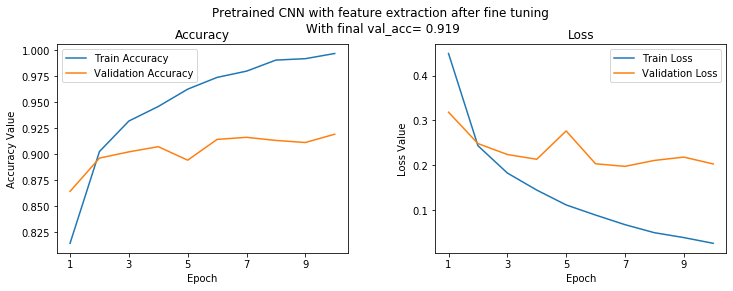

In [26]:
vggft_history = vggft_model.fit(x=train_imgs, y=train_labels,
                                epochs=10,
                                validation_data=(validation_imgs, validation_labels),
                                batch_size=batch_size,
                                verbose=1)
show_history(vggft_history, "Pretrained CNN with feature extraction after fine tuning")